In [66]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import json
import osmnx as ox
from shapely.geometry import Point, Polygon
import folium
import shapely

In [67]:
# Load the data
with open('/Users/cmartens/Documents/thesis_cf_martens/no_fly_zones/data/Alle statische zonering en andere gebieden in ED269 format - 22juli2024.JSON', "r", encoding="utf-8") as file:
    data = json.load(file)

# with open("/Users/cmartens/Documents/thesis_cf_martens/no_fly_zones/data/boundaries_netherlands.json", "r", encoding="utf-8") as file:
#     boundaries = json.load(file)

natura2000_zones = gpd.read_file("/Users/cmartens/Documents/thesis_cf_martens/no_fly_zones/data/natura2000.geojson")
natura2000_zones = natura2000_zones.to_crs(epsg=4326)

# boundaries = gpd.GeoDataFrame.from_features(boundaries["features"], crs=boundaries["crs"]["properties"]["name"])
# boundaries = boundaries.to_crs(epsg=4326)

In [68]:
features = data.get("features", [])
if not isinstance(features, list):
    raise ValueError("The JSON structure does not contain a list of features.")

# Extract relevant information
geo_zones = []
for feature in features:
    identifier = feature.get("identifier")
    country = feature.get("country")
    name = feature.get("name")
    zone_type = feature.get("type")
    restriction = feature.get("restriction")
    reason = ", ".join(feature.get("reason", [])) if isinstance(feature.get("reason", []), list) else ""

    # Extract 'zoneAuthority' (list)
    zone_authority = feature.get("zoneAuthority", [{}])
    zone_authority_name = zone_authority[0].get("name", "") if isinstance(zone_authority, list) else ""
    zone_authority_email = zone_authority[0].get("email", "") if isinstance(zone_authority, list) else ""

    # Extract 'applicability'
    applicability = feature.get("applicability", [{}])
    permanent = applicability[0].get("permanent", "") if isinstance(applicability, list) else ""

    # Extract 'message'
    message = feature.get("message", "")

    # Extract 'geometry' (list)
    geometry_list = feature.get("geometry", [])
    
    # Process multiple geometries
    for geometry in geometry_list:
        upper_limit = geometry.get("upperLimit", None)
        lower_limit = geometry.get("lowerLimit", None)
        uom_dimensions = geometry.get("uomDimensions", None)
        upper_vertical_reference = geometry.get("upperVerticalReference", None)
        lower_vertical_reference = geometry.get("lowerVerticalReference", None)

        # Extract geometry type and coordinates
        horizontal_projection = geometry.get("horizontalProjection", {})
        geometry_type = horizontal_projection.get("type", "")
        coordinates = horizontal_projection.get("coordinates", [])
        center = horizontal_projection.get("center", None)
        radius = horizontal_projection.get("radius", None)

        # Default geometry
        shapely_geometry = None

        # Convert different geometry types to Shapely
        if geometry_type == "Polygon":
            if isinstance(coordinates, list) and len(coordinates) > 0:
                shapely_geometry = Polygon(coordinates[0])  # Eerste ring als Polygon
        elif geometry_type == "Circle":
            if isinstance(center, list) and len(center) == 2:
                shapely_geometry = Point(center)  # Bewaar het middelpunt als een punt

        geo_zones.append({
            "identifier": identifier,
            "country": country,
            "name": name,
            "type": zone_type,
            "restriction": restriction,
            "reason": reason,
            "zoneAuthority_name": zone_authority_name,
            "permanent": permanent,
            "message": message,
            "upper_limit": upper_limit,
            "lower_limit": lower_limit,
            "geometry_type": geometry_type,
            "geometry": shapely_geometry,  # Dit is nu of een Polygon of een Point
            "circle_radius": radius if geometry_type == "Circle" else None  # Houd de radius apart
        })

# Convert to DataFrame
df = pd.DataFrame(geo_zones)

In [69]:
df

identifier country                                               name  \
0          2.a     NLD  Laagvliegroute 10 laagvlieggebied voor bemand ...   
1          2.b     NLD  GLV I (Noord-Drenthe) laagvlieggebied voor bem...   
2          2.c     NLD  GLV II (Midden-Drenthe) laagvlieggebied voor b...   
3          2.d     NLD  GLV III (West-Drenthe) laagvlieggebied voor be...   
4          2.e     NLD  GLV IV (Ginkelse Hei) laagvlieggebied voor bem...   
..         ...     ...                                                ...   
769    6.7.211     NLD  geografische zone van een beveiligd gebied of ...   
770    6.7.212     NLD  geografische zone van een beveiligd gebied of ...   
771    6.7.213     NLD  geografische zone van een beveiligd gebied of ...   
772    6.7.214     NLD  geografische zone van een beveiligd gebied of ...   
773    6.7.215     NLD  geografische zone van een beveiligd gebied of ...   

       type  restriction       reason  \
0    COMMON  CONDITIONAL  AIR_TRAFFIC   
1    COMMON  CONDITIONAL  AIR_TRAFFIC   
2    COMMON  CONDITIONAL  AIR_TRAFFIC   
3    COMMON  CONDITIONAL  AIR_TRAFFIC   
4    COMMON  CONDITIONAL  AIR_TRAFFIC   
..      ...          ...          ...   
769  COMMON  CONDITIONAL    SENSITIVE   
770  COMMON  CONDITIONAL    SENSITIVE   
771  COMMON  CONDITIONAL    SENSITIVE   
772  COMMON  CONDITIONAL    SENSITIVE   
773  COMMON  CONDITIONAL    SENSITIVE   

                              zoneAuthority_name permanent  \
0    Regeling zonering onbemande luchtvaartuigen       YES   
1    Regeling zonering onbemande luchtvaartuigen       YES   
2    Regeling zonering onbemande luchtvaartuigen       YES   
3    Regeling zonering onbemande luchtvaartuigen       YES   
4    Regeling zonering onbemande luchtvaartuigen       YES   
..                                           ...       ...   
769  Regeling zonering onbemande luchtvaartuigen       YES   
770  Regeling zonering onbemande luchtvaartuigen       YES   
771  Regeling zonering onbemande luchtvaartuigen       YES   
772  Regeling zonering onbemande luchtvaartuigen       YES   
773  Regeling zonering onbemande luchtvaartuigen       YES   

                                               message  upper_limit  \
0    OPEN A1/2 toegestaan tot max 30m hoogte boven ...          120   
1    OPEN A1/2 toegestaan tot max 30m hoogte boven ...          120   
2    OPEN A1/2 toegestaan tot max 30m hoogte boven ...          120   
3    OPEN A1/2 toegestaan tot max 30m hoogte boven ...          120   
4    OPEN A1/2 toegestaan tot max 30m hoogte boven ...          120   
..                                                 ...          ...   
769  OPEN cat. vluchten zijn hier verboden SPEC cat...          120   
770  OPEN cat. vluchten zijn hier verboden SPEC cat...          120   
771  OPEN cat. vluchten zijn hier verboden SPEC cat...          120   
772  OPEN cat. vluchten zijn hier verboden SPEC cat...          120   
773  OPEN cat. vluchten zijn hier verboden SPEC cat...          120   

     lower_limit geometry_type  \
0              0       Polygon   
1              0       Polygon   
2              0       Polygon   
3              0       Polygon   
4              0       Polygon   
..           ...           ...   
769            0        Circle   
770            0        Circle   
771            0        Circle   
772            0        Circle   
773            0        Circle   

                                              geometry  circle_radius  
0    POLYGON ((6.72026270898438 52.073290361593, 6....            NaN  
1    POLYGON ((6.72509722222222 53.0625, 6.65008611...            NaN  
2    POLYGON ((6.66645 52.7666972222222, 6.33689444...            NaN  
3    POLYGON ((6.35 52.9, 6.23333333333333 52.76666...            NaN  
4    POLYGON ((5.7417 52.0709222222222, 5.745911111...            NaN  
..                                                 ...            ...  
769          POINT (5.11083333333333 52.0236111111111)          500.0  
770

Omdat "Alle statische zonering en andere gebieden in ED269 format" nog data mist van Natura 2000 areas (alleen het wadden gebied zit erin) hebben we een losse data set van de natura 2000 gemerged met data.

In [70]:
natura2000_zones.rename(columns={"id": "identifier", "naamN2K": "name", "status": "message"}, inplace=True)
natura2000_zones.drop(columns=["vhnNew", "nr", "beschermin", "sitecodeV", "sitecodeH", "kadaster", "staatscour"], inplace=True)

In [71]:
# Add to natura2000_zones["name"] Natura 2000 Area
natura2000_zones["name"] = "Natura 2000 Area " + natura2000_zones["name"]

In [72]:
natura2000_zones['upper_limit'] = 120
natura2000_zones['lower_limit'] = 0

In [73]:
df

identifier country                                               name  \
0          2.a     NLD  Laagvliegroute 10 laagvlieggebied voor bemand ...   
1          2.b     NLD  GLV I (Noord-Drenthe) laagvlieggebied voor bem...   
2          2.c     NLD  GLV II (Midden-Drenthe) laagvlieggebied voor b...   
3          2.d     NLD  GLV III (West-Drenthe) laagvlieggebied voor be...   
4          2.e     NLD  GLV IV (Ginkelse Hei) laagvlieggebied voor bem...   
..         ...     ...                                                ...   
769    6.7.211     NLD  geografische zone van een beveiligd gebied of ...   
770    6.7.212     NLD  geografische zone van een beveiligd gebied of ...   
771    6.7.213     NLD  geografische zone van een beveiligd gebied of ...   
772    6.7.214     NLD  geografische zone van een beveiligd gebied of ...   
773    6.7.215     NLD  geografische zone van een beveiligd gebied of ...   

       type  restriction       reason  \
0    COMMON  CONDITIONAL  AIR_TRAFFIC   
1    COMMON  CONDITIONAL  AIR_TRAFFIC   
2    COMMON  CONDITIONAL  AIR_TRAFFIC   
3    COMMON  CONDITIONAL  AIR_TRAFFIC   
4    COMMON  CONDITIONAL  AIR_TRAFFIC   
..      ...          ...          ...   
769  COMMON  CONDITIONAL    SENSITIVE   
770  COMMON  CONDITIONAL    SENSITIVE   
771  COMMON  CONDITIONAL    SENSITIVE   
772  COMMON  CONDITIONAL    SENSITIVE   
773  COMMON  CONDITIONAL    SENSITIVE   

                              zoneAuthority_name permanent  \
0    Regeling zonering onbemande luchtvaartuigen       YES   
1    Regeling zonering onbemande luchtvaartuigen       YES   
2    Regeling zonering onbemande luchtvaartuigen       YES   
3    Regeling zonering onbemande luchtvaartuigen       YES   
4    Regeling zonering onbemande luchtvaartuigen       YES   
..                                           ...       ...   
769  Regeling zonering onbemande luchtvaartuigen       YES   
770  Regeling zonering onbemande luchtvaartuigen       YES   
771  Regeling zonering onbemande luchtvaartuigen       YES   
772  Regeling zonering onbemande luchtvaartuigen       YES   
773  Regeling zonering onbemande luchtvaartuigen       YES   

                                               message  upper_limit  \
0    OPEN A1/2 toegestaan tot max 30m hoogte boven ...          120   
1    OPEN A1/2 toegestaan tot max 30m hoogte boven ...          120   
2    OPEN A1/2 toegestaan tot max 30m hoogte boven ...          120   
3    OPEN A1/2 toegestaan tot max 30m hoogte boven ...          120   
4    OPEN A1/2 toegestaan tot max 30m hoogte boven ...          120   
..                                                 ...          ...   
769  OPEN cat. vluchten zijn hier verboden SPEC cat...          120   
770  OPEN cat. vluchten zijn hier verboden SPEC cat...          120   
771  OPEN cat. vluchten zijn hier verboden SPEC cat...          120   
772  OPEN cat. vluchten zijn hier verboden SPEC cat...          120   
773  OPEN cat. vluchten zijn hier verboden SPEC cat...          120   

     lower_limit geometry_type  \
0              0       Polygon   
1              0       Polygon   
2              0       Polygon   
3              0       Polygon   
4              0       Polygon   
..           ...           ...   
769            0        Circle   
770            0        Circle   
771            0        Circle   
772            0        Circle   
773            0        Circle   

                                              geometry  circle_radius  
0    POLYGON ((6.72026270898438 52.073290361593, 6....            NaN  
1    POLYGON ((6.72509722222222 53.0625, 6.65008611...            NaN  
2    POLYGON ((6.66645 52.7666972222222, 6.33689444...            NaN  
3    POLYGON ((6.35 52.9, 6.23333333333333 52.76666...            NaN  
4    POLYGON ((5.7417 52.0709222222222, 5.745911111...            NaN  
..                                                 ...            ...  
769          POINT (5.11083333333333 52.0236111111111)          500.0  
770

In [74]:
# Combine the two dataframes
df = pd.concat([df, natura2000_zones], ignore_index=True)

In [75]:
df.columns

Index(['identifier', 'country', 'name', 'type', 'restriction', 'reason',
       'zoneAuthority_name', 'permanent', 'message', 'upper_limit',
       'lower_limit', 'geometry_type', 'geometry', 'circle_radius'],
      dtype='object')

In [76]:
df

identifier country  \
0                                           2.a     NLD   
1                                           2.b     NLD   
2                                           2.c     NLD   
3                                           2.d     NLD   
4                                           2.e     NLD   
..                                          ...     ...   
977  n2000.a5100e23-b528-4330-a56d-81099de6b18e     NaN   
978  n2000.e73c4ea5-3cf8-48f0-85fb-73559fc64e99     NaN   
979  n2000.15428bc2-4d27-4b5e-8647-f09b12cde73e     NaN   
980  n2000.dc204964-b006-4672-b733-8d0fde3317db     NaN   
981  n2000.850e808d-2996-4356-8978-1e188b2e1e0c     NaN   

                                                  name    type  restriction  \
0    Laagvliegroute 10 laagvlieggebied voor bemand ...  COMMON  CONDITIONAL   
1    GLV I (Noord-Drenthe) laagvlieggebied voor bem...  COMMON  CONDITIONAL   
2    GLV II (Midden-Drenthe) laagvlieggebied voor b...  COMMON  CONDITIONAL   
3    GLV III (West-Drenthe) laagvlieggebied voor be...  COMMON  CONDITIONAL   
4    GLV IV (Ginkelse Hei) laagvlieggebied voor bem...  COMMON  CONDITIONAL   
..                                                 ...     ...          ...   
977                       Natura 2000 Area Bruine Bank     NaN          NaN   
978                        Natura 2000 Area Weerribben     NaN          NaN   
979                         Natura 2000 Area Waddenzee     NaN          NaN   
980                         Natura 2000 Area Waddenzee     NaN          NaN   
981                  Natura 2000 Area Krammer-Volkerak     NaN          NaN   

          reason                           zoneAuthority_name permanent  \
0    AIR_TRAFFIC  Regeling zonering onbemande luchtvaartuigen       YES   
1    AIR_TRAFFIC  Regeling zonering onbemande luchtvaartuigen       YES   
2    AIR_TRAFFIC  Regeling zonering onbemande luchtvaartuigen       YES   
3    AIR_TRAFFIC  Regeling zonering onbemande luchtvaartuigen       YES   
4    AIR_TRAFFIC  Regeling zonering onbemande luchtvaartuigen       YES   
..           ...                                          ...       ...   
977          NaN                                          NaN       NaN   
978          NaN                                          NaN       NaN   
979          NaN                                          NaN       NaN   
980          NaN                                          NaN       NaN   
981          NaN                                          NaN       NaN   

                                               message  upper_limit  \
0    OPEN A1/2 toegestaan tot max 30m hoogte boven ...          120   
1    OPEN A1/2 toegestaan tot max 30m hoogte boven ...          120   
2    OPEN A1/2 toegestaan tot max 30m hoogte boven ...          120   
3    OPEN A1/2 toegestaan tot max 30m hoogte boven ...          120   
4    OPEN A1/2 toegestaan tot max 30m hoogte boven ...          120   
..                                                 ...          ...   
977                Natura 2000-besluit 9 december 2021          120   
978  Natura 2000-besluit 06 januari 2014, wijziging...          120   
979                                 N2000-besluit 2009          120   
980  N2000-besluit 2009, N2000-wijzigingsbesluit 30...          120   
981              Ontwerpwijzigingsbesluit 30 juni 2017          120   

     lower_limit geometry_type  \
0              0       Polygon   
1              0       Polygon   
2              0       Polygon   
3              0       Polygon   
4              0       Polygon   
..           ...           ...   
977            0           NaN   
978            0           NaN   
979            0           NaN   
980            0           NaN   
981            0           NaN   

                                              geometry  circle_radius  
0    POLYGON ((6.72026270898438 52.073290361593, 6....            NaN  
1    POLYGON ((6.72509722222222 53.0625, 6.65008611...            NaN  


In [77]:
def EDA(column):
    print("Data type of", column, "column: ", df[column].dtype)
    print("NaN's in", column, "column: ", df[column].isna().sum())
    print("Unique values in", column, "column: ", len(df[column].unique()), "\n")
    print("Value counts of", column, "column: ")
    print(df[column].value_counts(), "\n")

In [78]:
EDA('identifier')

Data type of identifier column:  object
NaN's in identifier column:  0
Unique values in identifier column:  982 

Value counts of identifier column: 
identifier
n2000.850e808d-2996-4356-8978-1e188b2e1e0c    1
2.a                                           1
2.b                                           1
2.c                                           1
2.d                                           1
                                             ..
3.ss                                          1
3.tt                                          1
3.uu                                          1
3.vv                                          1
3.ww                                          1
Name: count, Length: 982, dtype: int64 



In [79]:
EDA('country')

Data type of country column:  object
NaN's in country column:  208
Unique values in country column:  2 

Value counts of country column: 
country
NLD    774
Name: count, dtype: int64 



In [80]:
EDA('name')

Data type of name column:  object
NaN's in name column:  0
Unique values in name column:  332 

Value counts of name column: 
name
Industriegebied met risicos op zware ongevallen                                   257
geografische zone van een beveiligd gebied of een locatie met vitale processen    213
Gebied met verbod vanuit beveiligingsoverwegingen                                 125
Nabijheid van vliegveld voor bemand luchtverkeer De PEEL CTR                        4
Nabijheid van vliegveld voor bemand luchtverkeer EHKD DE KOOY CTR                   3
                                                                                 ... 
Arnhemse Heide Defensiegebied                                                       1
ASK OldeBroek Defensiegebied                                                        1
Assen Defensiegebied                                                                1
Beekhuizerzand Defensiegebied                                                       1
GLV I (No

In [81]:
df[df['restriction'] == "REQ_AUTHORISATION"].name.unique()

array(['Defensie oefengebied EHR3 (Oldebroek)',
       'Defensie oefengebied EHR 3A (Oldebroek)',
       'Defensie oefengebied EHR 4 (Vliehors)',
       'Defensie oefengebied EHR 4B (Vliehors)',
       'Defensie oefengebied EHR 4C (Vliehors)',
       'Defensie oefengebied EHR 4D (Vliehors)',
       'Defensie oefengebied EHR 4F (Vliehors)',
       'Defensie oefengebied EHR 8 (Den Helder)',
       'Defensie oefengebied EHR 9 (Harskamp)',
       'Defensie oefengebied EHR 61 (Arnhemse Heide)',
       'Defensie oefengebied EHR 62 (Reek)',
       'Defensie oefengebied EHR 63 (Riel)',
       'Defensie oefengebied EHR 65 (Witten; Assen)',
       'Defensie oefengebied EHR 66 (NLR RPAS testcentrum Low)',
       'Defensie oefengebied EHTSA 1A (De Peel A)',
       'Defensie oefengebied  EHTSA 1B (De Peel B)',
       'Defensie oefengebied EHR 2 (Marnewaard)',
       'Defensie oefengebied EHR 2A (Marnewaard A)',
       'Defensie oefengebied EHR 2B (Marnewaard B)',
       'Defensie oefengebied EHR 2C

In [82]:
df[df['restriction'] == "CONDITIONAL"].name.unique()

array(['Laagvliegroute 10 laagvlieggebied voor bemand luchtverkeer\nZone loopt tot 1NM (1852m) aan weerszijde van de lijn',
       'GLV I (Noord-Drenthe) laagvlieggebied voor bemand luchtverkeer',
       'GLV II (Midden-Drenthe) laagvlieggebied voor bemand luchtverkeer',
       'GLV III (West-Drenthe) laagvlieggebied voor bemand luchtverkeer',
       'GLV IV (Ginkelse Hei) laagvlieggebied voor bemand luchtverkeer',
       'GLV V (Oirschot) laagvlieggebied voor bemand luchtverkeer',
       'GLV VI (Salland) laagvlieggebied voor bemand luchtverkeer',
       'GLV VII (Veluwe/Randmeren) laagvlieggebied voor bemand luchtverkeer',
       'GLV VIII (De Peel) laagvlieggebied voor bemand luchtverkeer',
       'GLV IX (Maas/Waal) laagvlieggebied voor bemand luchtverkeer',
       'GLV X (Voorne-Putten/Hoeksewaard) laagvlieggebied voor bemand luchtverkeer',
       'GLV XI (Wieringermeerpolder) laagvlieggebied voor bemand luchtverkeer',
       'GLV XII (Noordzee) laagvlieggebied voor bemand luchtve

In [83]:
df[df['restriction'] == "PROHIBITED"].name.unique()

array(['Verboden gebied voor al het luchtverkeer EHP25 (Drakensteijn Castle)',
       'Verboden gebied voor al het luchtverkeer EHP26 (royal palaces and government buildings)',
       'Verboden gebied voor al het luchtverkeer EHP26A (Scheveningen)',
       'Verboden gebied tijdens Dodenherdenking 4 mei EHTSA 16 (Amsterdam/Dam)',
       'Verboden gebied tijdens Dodenherdenking 4 mei EHTSA 16a (Amsterdam/Dam)',
       'Verboden gebied tijdens Dodenherdenking 4 mei EHTSA 17 (Apeldoorn/Loenen)',
       'Verboden gebied tijdens Dodenherdenking 4 mei EHTSA 18 (Bloemendaal/Overveen)',
       'Verboden gebied tijdens Dodenherdenking 4 mei EHTSA 19 (Rhenen/Grebbeberg)',
       'Verboden gebied tijdens Dodenherdenking 4 mei EHTSA 21 (Westerbork)',
       'Millieubeschermingsgebied Waddenzee'], dtype=object)

In [84]:
# Functie om zones te categoriseren
def categorize_zone(name):
    name = name.lower()  # Converteer naar kleine letters voor consistente vergelijking

    # **Trauma- en reddingshelikopter landingsplaatsen**
    if "traumahelikopter" in name or "reddingshelikopter" in name or "TRAUMAHELICOPTER" in name:
        return "Special Operations"
    
    # **Nabijheid van vliegvelden (CTR - Controlled Traffic Region)**
    elif "ctr" in name:
        return "Aviation"

    elif "nabijheid van vliegveld" in name:
        return "Aviation"

    # **Defensiezones en militaire oefengebieden**
    elif "defensiegebied" in name or "ehd" in name:
        return "Military"

    # **Permanent gereserveerde luchtruimen (Restricted Airspace - EHR)**
    elif "ehr" in name:
        return "Military"

    # **Tijdelijk gereserveerde luchtruimen (Temporary Reserved Airspace - EHTRA)**
    elif "ehtra" in name:
        return "Military"

    # Test- en dronegebieden (Special Activity Airspace - EHTSA)**
    elif "ehtsa" in name:
        return "Military"

    # **Laagvliegzones (Military Low Flying Area - EHD)**
    elif "laagvliegroute" in name or "laagvlieggebied" in name or name.startswith("glv"):
        return "Military"

    # **Havengebieden met risico’s op zware ongevallen**
    elif "havengebied" in name or "industriegebied" in name:
        return "Industry"

    # **Gebieden met speciale beveiliging**
    elif "beveiligingsoverwegingen" in name or "vitaal proces" in name or "vitale processen" in name:
        return "Security"

    # **Milieubeschermingsgebieden**
    elif "natura" in name or "millieubeschermingsgebied" in name or "waddenzee" in name:
        return "Environment"

    # **Verboden gebieden voor luchtverkeer (EHP - Prohibited Airspace)**
    elif "verboden gebied" in name or "ehp" in name:
        return "Security"

    # **Oefengebieden voor externe blusinstallaties van helikopters**
    elif "blusinstallatie" in name:
        return "Special Operations"

    # **Anders: onbekende categorie**
    else:
        return "Unknown"

In [85]:
# Functie om zones te categoriseren
def air_type(name):
    name = name.lower()  # Converteer naar kleine letters voor consistente vergelijking

    # **Trauma- en reddingshelikopter landingsplaatsen**
    if "traumahelikopter" in name or "reddingshelikopter" in name or "TRAUMAHELICOPTER" in name:
        return "Air Ambulance Landing Sites"
    
    # **Nabijheid van vliegvelden (CTR - Controlled Traffic Region)**
    elif "ctr" in name:
        return "CTR Zones"

    elif "nabijheid van vliegveld" in name:
        return "Airports"

    # **Defensiezones en militaire oefengebieden**
    elif "defensiegebied" in name or "ehd" in name:
        return "General Training Area (EHD)"

    # **Permanent gereserveerde luchtruimen (Restricted Airspace - EHR)**
    elif "ehr" in name:
        return "Permanently Reserved Airspace (EHR)"

    # **Tijdelijk gereserveerde luchtruimen (Temporary Reserved Airspace - EHTRA)**
    elif "ehtra" in name:
        return "Temporarily Reserved Airspace (EHTRA)"

    # **Test- en dronegebieden (Special Activity Airspace - EHTSA)**
    elif "ehtsa" in name:
        return "Temporarily Segregated Airspace (EHTSA)"

    # **Laagvliegzones (Military Low Flying Area - EHD)**
    elif "laagvliegroute" in name or "laagvlieggebied" in name or name.startswith("glv"):
        return "Low-Flying Area (GLV) and low flight routes"

    # **Havengebieden met risico’s op zware ongevallen**
    elif "havengebied" in name or "industriegebied" in name:
        return "High-Risk Areas"

    # **Gebieden met speciale beveiliging**
    elif "beveiligingsoverwegingen" in name or "vitaal proces" in name or "vitale processen" in name:
        return "Restricted Zones"

    # **Milieubeschermingsgebieden**
    elif "natura" in name or "millieubeschermingsgebied" in name or "waddenzee" in name:
        return "Protected Nature Reserves"

    # **Verboden gebieden voor luchtverkeer (EHP - Prohibited Airspace)**
    elif "verboden gebied" in name or "ehp" in name:
        return "Prohibited Airspace (EHP)"

    # **Oefengebieden voor externe blusinstallaties van helikopters**
    elif "blusinstallatie" in name:
        return "Firefighting Training Areas"

    # **Anders: onbekende categorie**
    else:
        return "Unknown"

In [86]:
df["category"] = df["name"].apply(categorize_zone)
df["air_type"] = df["name"].apply(air_type)

In [87]:
df["category"].value_counts()

category
Security              341
Industry              270
Environment           209
Military               91
Aviation               43
Special Operations     28
Name: count, dtype: int64

In [88]:
df["air_type"].value_counts()

air_type
Restricted Zones                               338
High-Risk Areas                                270
Protected Nature Reserves                      209
CTR Zones                                       25
Air Ambulance Landing Sites                     23
Temporarily Segregated Airspace (EHTSA)         21
Permanently Reserved Airspace (EHR)             20
General Training Area (EHD)                     20
Low-Flying Area (GLV) and low flight routes     18
Airports                                        18
Temporarily Reserved Airspace (EHTRA)           12
Firefighting Training Areas                      5
Prohibited Airspace (EHP)                        3
Name: count, dtype: int64

In [89]:
def no_fly_zones(air_type):
    if air_type == "Restricted Zones":
        return True
    
    elif air_type == "High-Risk Areas":
        return True
    
    elif air_type == "Protected Nature Reserves":
        return True

    elif air_type == "CTR Zones":
        return False

    elif air_type == "Air Ambulance Landing Sites":
        return True
    
    elif air_type == "Temporarily Segregated Airspace (EHTSA)":
        return False

    elif air_type == "Permanently Reserved Airspace (EHR)":
        return True

    elif air_type == "General Training Area (EHD)":
        return True

    elif air_type == "Low-Flying Area (GLV) and low flight routes":
        return False

    elif air_type == "Airports":
        return False

    elif air_type == "Temporarily Reserved Airspace (EHTRA)":
        return False

    elif air_type == "Prohibited Airspace (EHP)":
        return True

    elif air_type == "Firefighting Training Areas":
        return True

    else:
        return False
    

In [90]:
df["no_fly"] = df["air_type"].apply(no_fly_zones)

In [91]:
df['type'] = 'UAV geozone'

In [92]:
df

identifier country  \
0                                           2.a     NLD   
1                                           2.b     NLD   
2                                           2.c     NLD   
3                                           2.d     NLD   
4                                           2.e     NLD   
..                                          ...     ...   
977  n2000.a5100e23-b528-4330-a56d-81099de6b18e     NaN   
978  n2000.e73c4ea5-3cf8-48f0-85fb-73559fc64e99     NaN   
979  n2000.15428bc2-4d27-4b5e-8647-f09b12cde73e     NaN   
980  n2000.dc204964-b006-4672-b733-8d0fde3317db     NaN   
981  n2000.850e808d-2996-4356-8978-1e188b2e1e0c     NaN   

                                                  name         type  \
0    Laagvliegroute 10 laagvlieggebied voor bemand ...  UAV geozone   
1    GLV I (Noord-Drenthe) laagvlieggebied voor bem...  UAV geozone   
2    GLV II (Midden-Drenthe) laagvlieggebied voor b...  UAV geozone   
3    GLV III (West-Drenthe) laagvlieggebied voor be...  UAV geozone   
4    GLV IV (Ginkelse Hei) laagvlieggebied voor bem...  UAV geozone   
..                                                 ...          ...   
977                       Natura 2000 Area Bruine Bank  UAV geozone   
978                        Natura 2000 Area Weerribben  UAV geozone   
979                         Natura 2000 Area Waddenzee  UAV geozone   
980                         Natura 2000 Area Waddenzee  UAV geozone   
981                  Natura 2000 Area Krammer-Volkerak  UAV geozone   

     restriction       reason                           zoneAuthority_name  \
0    CONDITIONAL  AIR_TRAFFIC  Regeling zonering onbemande luchtvaartuigen   
1    CONDITIONAL  AIR_TRAFFIC  Regeling zonering onbemande luchtvaartuigen   
2    CONDITIONAL  AIR_TRAFFIC  Regeling zonering onbemande luchtvaartuigen   
3    CONDITIONAL  AIR_TRAFFIC  Regeling zonering onbemande luchtvaartuigen   
4    CONDITIONAL  AIR_TRAFFIC  Regeling zonering onbemande luchtvaartuigen   
..           ...          ...                                          ...   
977          NaN          NaN                                          NaN   
978          NaN          NaN                                          NaN   
979          NaN          NaN                                          NaN   
980          NaN          NaN                                          NaN   
981          NaN          NaN                                          NaN   

    permanent                                            message  upper_limit  \
0         YES  OPEN A1/2 toegestaan tot max 30m hoogte boven ...          120   
1         YES  OPEN A1/2 toegestaan tot max 30m hoogte boven ...          120   
2         YES  OPEN A1/2 toegestaan tot max 30m hoogte boven ...          120   
3         YES  OPEN A1/2 toegestaan tot max 30m hoogte boven ...          120   
4         YES  OPEN A1/2 toegestaan tot max 30m hoogte boven ...          120   
..        ...                                                ...          ...   
977       NaN                Natura 2000-besluit 9 december 2021          120   
978       NaN  Natura 2000-besluit 06 januari 2014, wijziging...          120   
979       NaN                                 N2000-besluit 2009          120   
980       NaN  N2000-besluit 2009, N2000-wijzigingsbesluit 30...          120   
981       NaN              Ontwerpwijzigingsbesluit 30 juni 2017          120   

     lower_limit geometry_type  \
0              0       Polygon   
1              0       Polygon   
2              0       Polygon   
3              0       Polygon   
4              0       Polygon   
..           ...           ...   
977            0           NaN   
978            0           NaN   
979            0           NaN   
980            0           NaN   
981            0           NaN   

                                              geometry  circle_radius  \
0    POLYGON ((6.72026270898438 52.073290361593, 6....            NaN   
1    POLYG

In [93]:
EDA('type')
df.drop(columns=['type'], inplace=True)

Data type of type column:  object
NaN's in type column:  0
Unique values in type column:  1 

Value counts of type column: 
type
UAV geozone    982
Name: count, dtype: int64 



In [94]:
EDA('restriction')

Data type of restriction column:  object
NaN's in restriction column:  208
Unique values in restriction column:  4 

Value counts of restriction column: 
restriction
CONDITIONAL          713
REQ_AUTHORISATION     51
PROHIBITED            10
Name: count, dtype: int64 



In [95]:
df[df['restriction'] == "PROHIBITED"]

identifier country                                               name  \
500       7.28     NLD  Verboden gebied voor al het luchtverkeer EHP25...   
501       7.29     NLD  Verboden gebied voor al het luchtverkeer EHP26...   
502       7.30     NLD  Verboden gebied voor al het luchtverkeer EHP26...   
554       7.82     NLD  Verboden gebied tijdens Dodenherdenking 4 mei ...   
555       7.83     NLD  Verboden gebied tijdens Dodenherdenking 4 mei ...   
556       7.84     NLD  Verboden gebied tijdens Dodenherdenking 4 mei ...   
557       7.85     NLD  Verboden gebied tijdens Dodenherdenking 4 mei ...   
558       7.86     NLD  Verboden gebied tijdens Dodenherdenking 4 mei ...   
559       7.87     NLD  Verboden gebied tijdens Dodenherdenking 4 mei ...   
560        8.1     NLD                Millieubeschermingsgebied Waddenzee   

    restriction     reason                                 zoneAuthority_name  \
500  PROHIBITED  SENSITIVE  Regeling beperking of verbod uitoefening burge...   
501  PROHIBITED  SENSITIVE  Regeling beperking of verbod uitoefening burge...   
502  PROHIBITED  SENSITIVE  Regeling beperking of verbod uitoefening burge...   
554  PROHIBITED  SENSITIVE  Regeling beperking of verbod uitoefening burge...   
555  PROHIBITED  SENSITIVE  Regeling beperking of verbod uitoefening burge...   
556  PROHIBITED  SENSITIVE  Regeling beperking of verbod uitoefening burge...   
557  PROHIBITED  SENSITIVE  Regeling beperking of verbod uitoefening burge...   
558  PROHIBITED  SENSITIVE  Regeling beperking of verbod uitoefening burge...   
559  PROHIBITED  SENSITIVE  Regeling beperking of verbod uitoefening burge...   
560  PROHIBITED  SENSITIVE   Besluit Beperkingen Burgerluchtverkeer Waddenzee   

    permanent                                            message  upper_limit  \
500       YES  Alle vluchten zijn hier verboden / All flights...          610   
501       YES  Alle vluchten zijn hier verboden / All flights...          610   
502       YES  Alle vluchten zijn hier verboden / All flights...          610   
554       YES  Alle vluchten zijn hier verboden op 4 mei / al...         1676   
555       YES  Alle vluchten zijn hier verboden op 4 mei / al...         4420   
556       YES  Alle vluchten zijn hier verboden op 4 mei / al...         1676   
557       YES  Alle vluchten zijn hier verboden op 4 mei / al...         1676   
558       YES  Alle vluchten zijn hier verboden op 4 mei / al...         1676   
559       YES  Alle vluchten zijn hier verboden op 4 mei / al...          914   
560       YES  Alle vluchten zijn hier verboden / All flights...          457   

     lower_limit geometry_type  \
500            0        Circle   
501            0       Polygon   
502            0       Polygon   
554            0        Circle   
555            0        Circle   
556            0        Circle   
557            0        Circle   
558            0        Circle   
559            0        Circle   
560            0       Polygon   

                                              geometry  circle_radius  \
500          POINT (5.22722222222222 52.1797222222222)          926.0   
501  POLYGON ((4.30555555555556 52.0619444444444, 4...            NaN   
502  POLYGON ((4.27722222222222 52.1072222222222, 4...            NaN   
554                       POINT (4.9 52.3666666666667)         3704.0   
555                       POINT (4.9 52.3666666666667)         3704.0   
556          POINT (6.01666666666667 52.1166666666667)         3704.0   
557                      POINT (4.61666666666667 52.4)         3704.0   
558          POINT (5.59166666666667 51.9583333333333)         3704.0   
559          POINT (6.56964166666667 52.9209805555556)         2778.0   
560  POLYGON ((4.572805556 52.95272222, 4.575111111...            NaN   

        category                                 air_type  no_fly  
500     Security                Prohibited Airspace (EHP)    True  
501     Security                Prohibited Airspace (EHP)

Dit betekent dat vliegen in de zone is toegestaan onder bepaalde voorwaarden. Er gelden specifieke regels of beperkingen (bijvoorbeeld maximale hoogte, tijdsvensters, of operationele vereisten). Dit betekent niet per se dat er een aparte autorisatie nodig is, maar wel dat er aan bepaalde restricties voldaan moet worden.

In [96]:
df[df['restriction'] == "CONDITIONAL"]

identifier country                                               name  \
0          2.a     NLD  Laagvliegroute 10 laagvlieggebied voor bemand ...   
1          2.b     NLD  GLV I (Noord-Drenthe) laagvlieggebied voor bem...   
2          2.c     NLD  GLV II (Midden-Drenthe) laagvlieggebied voor b...   
3          2.d     NLD  GLV III (West-Drenthe) laagvlieggebied voor be...   
4          2.e     NLD  GLV IV (Ginkelse Hei) laagvlieggebied voor bem...   
..         ...     ...                                                ...   
769    6.7.211     NLD  geografische zone van een beveiligd gebied of ...   
770    6.7.212     NLD  geografische zone van een beveiligd gebied of ...   
771    6.7.213     NLD  geografische zone van een beveiligd gebied of ...   
772    6.7.214     NLD  geografische zone van een beveiligd gebied of ...   
773    6.7.215     NLD  geografische zone van een beveiligd gebied of ...   

     restriction       reason                           zoneAuthority_name  \
0    CONDITIONAL  AIR_TRAFFIC  Regeling zonering onbemande luchtvaartuigen   
1    CONDITIONAL  AIR_TRAFFIC  Regeling zonering onbemande luchtvaartuigen   
2    CONDITIONAL  AIR_TRAFFIC  Regeling zonering onbemande luchtvaartuigen   
3    CONDITIONAL  AIR_TRAFFIC  Regeling zonering onbemande luchtvaartuigen   
4    CONDITIONAL  AIR_TRAFFIC  Regeling zonering onbemande luchtvaartuigen   
..           ...          ...                                          ...   
769  CONDITIONAL    SENSITIVE  Regeling zonering onbemande luchtvaartuigen   
770  CONDITIONAL    SENSITIVE  Regeling zonering onbemande luchtvaartuigen   
771  CONDITIONAL    SENSITIVE  Regeling zonering onbemande luchtvaartuigen   
772  CONDITIONAL    SENSITIVE  Regeling zonering onbemande luchtvaartuigen   
773  CONDITIONAL    SENSITIVE  Regeling zonering onbemande luchtvaartuigen   

    permanent                                            message  upper_limit  \
0         YES  OPEN A1/2 toegestaan tot max 30m hoogte boven ...          120   
1         YES  OPEN A1/2 toegestaan tot max 30m hoogte boven ...          120   
2         YES  OPEN A1/2 toegestaan tot max 30m hoogte boven ...          120   
3         YES  OPEN A1/2 toegestaan tot max 30m hoogte boven ...          120   
4         YES  OPEN A1/2 toegestaan tot max 30m hoogte boven ...          120   
..        ...                                                ...          ...   
769       YES  OPEN cat. vluchten zijn hier verboden SPEC cat...          120   
770       YES  OPEN cat. vluchten zijn hier verboden SPEC cat...          120   
771       YES  OPEN cat. vluchten zijn hier verboden SPEC cat...          120   
772       YES  OPEN cat. vluchten zijn hier verboden SPEC cat...          120   
773       YES  OPEN cat. vluchten zijn hier verboden SPEC cat...          120   

     lower_limit geometry_type  \
0              0       Polygon   
1              0       Polygon   
2              0       Polygon   
3              0       Polygon   
4              0       Polygon   
..           ...           ...   
769            0        Circle   
770            0        Circle   
771            0        Circle   
772            0        Circle   
773            0        Circle   

                                              geometry  circle_radius  \
0    POLYGON ((6.72026270898438 52.073290361593, 6....            NaN   
1    POLYGON ((6.72509722222222 53.0625, 6.65008611...            NaN   
2    POLYGON ((6.66645 52.7666972222222, 6.33689444...            NaN   
3    POLYGON ((6.35 52.9, 6.23333333333333 52.76666...            NaN   
4    POLYGON ((5.7417 52.0709222222222, 5.745911111...            NaN   
..                                                 ...            ...   
769          POINT (5.11083333333333 52.0236111111111)          500.0   
770          POINT (4.57472222222222 52.3430555555556)          500.0   
771          POINT (4.57916666666667 52.3452777777778)          500.0   
772          POINT (4.57555555

In [97]:
df[df['restriction'] == "REQ_AUTHORISATION"]

identifier country                                               name  \
503       7.31     NLD              Defensie oefengebied EHR3 (Oldebroek)   
504       7.32     NLD            Defensie oefengebied EHR 3A (Oldebroek)   
505       7.33     NLD              Defensie oefengebied EHR 4 (Vliehors)   
506       7.34     NLD             Defensie oefengebied EHR 4B (Vliehors)   
507       7.35     NLD             Defensie oefengebied EHR 4C (Vliehors)   
508       7.36     NLD             Defensie oefengebied EHR 4D (Vliehors)   
509       7.37     NLD             Defensie oefengebied EHR 4F (Vliehors)   
510       7.38     NLD            Defensie oefengebied EHR 8 (Den Helder)   
511       7.39     NLD              Defensie oefengebied EHR 9 (Harskamp)   
512       7.40     NLD       Defensie oefengebied EHR 61 (Arnhemse Heide)   
513       7.41     NLD                 Defensie oefengebied EHR 62 (Reek)   
514       7.42     NLD                 Defensie oefengebied EHR 63 (Riel)   
515       7.43     NLD        Defensie oefengebied EHR 65 (Witten; Assen)   
516       7.44     NLD  Defensie oefengebied EHR 66 (NLR RPAS testcent...   
517       7.45     NLD          Defensie oefengebied EHTSA 1A (De Peel A)   
518       7.46     NLD         Defensie oefengebied  EHTSA 1B (De Peel B)   
519       7.47     NLD            Defensie oefengebied EHR 2 (Marnewaard)   
520       7.48     NLD         Defensie oefengebied EHR 2A (Marnewaard A)   
521       7.49     NLD         Defensie oefengebied EHR 2B (Marnewaard B)   
522       7.50     NLD         Defensie oefengebied EHR 2C (Marnewaard C)   
523       7.51     NLD                      Defensie oefengebied EHTRA 11   
524       7.52     NLD             Defensie oefengebied EHTRA 14 (Drente)   
525       7.53     NLD            Defensie oefengebied EHTRA 14B (Drente)   
526       7.54     NLD            Defensie oefengebied EHTRA 14C (Drente)   
527       7.55     NLD                       Defensie oefengebied EHD 41A   
528       7.56     NLD                       Defensie oefengebied EHD 41B   
529       7.57     NLD                       Defensie oefengebied EHD 41C   
530       7.58     NLD                        Defensie oefengebied EHD 42   
531       7.59     NLD         Defensie oefengebied EHR 49 (Breezanddijk)   
532       7.60     NLD        Defensie oefengebied EHTSA 50 (Marne; RPAS)   
533       7.61     NLD      Defensie oefengebied EHTSA 51 (De Haar; RPAS)   
534       7.62     NLD      Defensie oefengebied EHTSA 52 (Havelte; RPAS)   
535       7.63     NLD  Defensie oefengebied EHTSA 53 (Beekhuizerzand;...   
536       7.64     NLD  Defensie oefengebied EHTSA 54 (Ermelosche Heid...   
537       7.65     NLD   Defensie oefengebied EHTSA 55 (Vlasakkers; RPAS)   
538       7.66     NLD  Defensie oefengebied EHTSA 56 (Leusderheide; R...   
539       7.67     NLD  Defensie oefengebied EHTSA 57 (Rucphense Heide...   
540       7.68     NLD        Defensie oefengebied EHTRA 58 (Regte Heide)   
541       7.69     NLD       Defensie oefengebied EHTRA 59 (Leusderheide)   
542       7.70     NLD  Defensie oefengebied EHR 64 (Kruispeel/Achterb...   
543       7.71     NLD        Defensie oefengebied EHTSA 67 (Kraggenburg)   
544       7.72     NLD              Defensie oefengebied EHTRA 72 (Wamel)   
545       7.73     NLD  Defensie oefengebied EHTRA 80 (Deelen High) AM...   
546       7.74     NLD          Defensie oefengebied EHTRA 81 (Maas/Waal)   
547       7.75     NLD         Defensie oefengebied EHTRA 82 (Zaltbommel)   
548       7.76     NLD             Defensie oefengebied EHTRA 83 (Ginkel)   
549       7.77     NLD              Defensie oefengebied EHTRA 84 (Uddel)   
550       7.78     NLD         Defensie oefengebied EHTSA 85 (Deelen Low)   
551       7.79     NLD  Defensie oefengebied EHTSA 100 (Combi Recovery...   
552       7.80     NLD  Defensie oefengebied EHTSA 101 (Emmer-Compascuum)   
553       7.81     NLD           Defensie oefengebied EHTSA 102 (De Krim)   


In [98]:
EDA('reason')

Data type of reason column:  object
NaN's in reason column:  208
Unique values in reason column:  4 

Value counts of reason column: 
reason
SENSITIVE      618
AIR_TRAFFIC    105
OTHER           51
Name: count, dtype: int64 



In [99]:
EDA('zoneAuthority_name')

Data type of zoneAuthority_name column:  object
NaN's in zoneAuthority_name column:  208
Unique values in zoneAuthority_name column:  8 

Value counts of zoneAuthority_name column: 
zoneAuthority_name
Regeling zonering onbemande luchtvaartuigen                                              412
Seveso locatie 1 okt2023                                                                 257
Regeling beperking of verbod uitoefening burgerluchtverkeer in bepaalde gebieden 2014     60
Regeling onbemande luchtvaartuigen                                                        27
Defensie                                                                                  16
Regeling zonering onbemande luchtvaartuigen                                                1
Besluit Beperkingen Burgerluchtverkeer Waddenzee                                           1
Name: count, dtype: int64 



In [100]:
EDA('permanent')

Data type of permanent column:  object
NaN's in permanent column:  208
Unique values in permanent column:  2 

Value counts of permanent column: 
permanent
YES    774
Name: count, dtype: int64 



In [101]:
EDA('message')

Data type of message column:  object
NaN's in message column:  0
Unique values in message column:  48 

Value counts of message column: 
message
OPEN cat. vluchten zijn hier verboden SPEC cat. vluchten vereisen een privilege op de exploitatievergunning / Flights in the OPEN cat. are not allowed in SPEC cat. a privilege on the OA is required     635
Vluchten in de OPEN categorie zijn hier niet toegestaan / Flights in the OPEN category are not allowed here                                                                                                55
Alle vuchten zijn hier verboden tenzij er toestemming is gegeven door de Militaire luchverkeersdienstverlener / All flights are prohibited unless permission is granted (Military air traffic control)     51
Natura 2000-besluit 2010                                                                                                                                                                                   39
Natura 2000-besluit 4 juni 2013

In [102]:
df[df['message'] == "Alle vluchten zijn hier verboden op 4 mei / all flights are prohibted on the 4th of may"]

identifier country                                               name  \
554       7.82     NLD  Verboden gebied tijdens Dodenherdenking 4 mei ...   
555       7.83     NLD  Verboden gebied tijdens Dodenherdenking 4 mei ...   
556       7.84     NLD  Verboden gebied tijdens Dodenherdenking 4 mei ...   
557       7.85     NLD  Verboden gebied tijdens Dodenherdenking 4 mei ...   
558       7.86     NLD  Verboden gebied tijdens Dodenherdenking 4 mei ...   
559       7.87     NLD  Verboden gebied tijdens Dodenherdenking 4 mei ...   

    restriction     reason                                 zoneAuthority_name  \
554  PROHIBITED  SENSITIVE  Regeling beperking of verbod uitoefening burge...   
555  PROHIBITED  SENSITIVE  Regeling beperking of verbod uitoefening burge...   
556  PROHIBITED  SENSITIVE  Regeling beperking of verbod uitoefening burge...   
557  PROHIBITED  SENSITIVE  Regeling beperking of verbod uitoefening burge...   
558  PROHIBITED  SENSITIVE  Regeling beperking of verbod uitoefening burge...   
559  PROHIBITED  SENSITIVE  Regeling beperking of verbod uitoefening burge...   

    permanent                                            message  upper_limit  \
554       YES  Alle vluchten zijn hier verboden op 4 mei / al...         1676   
555       YES  Alle vluchten zijn hier verboden op 4 mei / al...         4420   
556       YES  Alle vluchten zijn hier verboden op 4 mei / al...         1676   
557       YES  Alle vluchten zijn hier verboden op 4 mei / al...         1676   
558       YES  Alle vluchten zijn hier verboden op 4 mei / al...         1676   
559       YES  Alle vluchten zijn hier verboden op 4 mei / al...          914   

     lower_limit geometry_type                                   geometry  \
554            0        Circle               POINT (4.9 52.3666666666667)   
555            0        Circle               POINT (4.9 52.3666666666667)   
556            0        Circle  POINT (6.01666666666667 52.1166666666667)   
557            0        Circle              POINT (4.61666666666667 52.4)   
558            0        Circle  POINT (5.59166666666667 51.9583333333333)   
559            0        Circle  POINT (6.56964166666667 52.9209805555556)   

     circle_radius  category                                 air_type  no_fly  
554         3704.0  Military  Temporarily Segregated Airspace (EHTSA)   False  
555         3704.0  Military  Temporarily Segregated Airspace (EHTSA)   False  
556         3704.0  Military  Temporarily Segregated Airspace (EHTSA)   False  
557         3704.0  Military  Temporarily Segregated Airspace (EHTSA)   False  
558         3704.0  Military  Temporarily Segregated Airspace (EHTSA)   False  
559         2778.0  Military  Temporarily Segregated Airspace (EHTSA)   False

Staan als permanent aangegeven maar is tijdelijk.

In [103]:
# delete rows with message "Alle vluchten zijn hier verboden op 4 mei / all flights are prohibted on the 4th of may" 
df = df[df['message'] != "Alle vluchten zijn hier verboden op 4 mei / all flights are prohibted on the 4th of may"]

In [104]:
EDA('upper_limit')

Data type of upper_limit column:  int64
NaN's in upper_limit column:  0
Unique values in upper_limit column:  20 

Value counts of upper_limit column: 
upper_limit
120      894
914       30
610        9
183        7
1981       5
762        5
457        4
305        4
5944       4
1676       3
366        2
1219       1
1524       1
1798       1
5639       1
3566       1
20117      1
2896       1
7468       1
3962       1
Name: count, dtype: int64 



In [105]:
EDA('lower_limit')

Data type of lower_limit column:  int64
NaN's in lower_limit column:  0
Unique values in lower_limit column:  5 

Value counts of lower_limit column: 
lower_limit
0      968
914      3
366      3
305      1
610      1
Name: count, dtype: int64 



In [106]:
df[df['lower_limit'] == 914]

identifier country                                               name  \
504       7.32     NLD            Defensie oefengebied EHR 3A (Oldebroek)   
523       7.51     NLD                      Defensie oefengebied EHTRA 11   
545       7.73     NLD  Defensie oefengebied EHTRA 80 (Deelen High) AM...   

           restriction reason  \
504  REQ_AUTHORISATION  OTHER   
523  REQ_AUTHORISATION  OTHER   
545  REQ_AUTHORISATION  OTHER   

                                    zoneAuthority_name permanent  \
504  Regeling beperking of verbod uitoefening burge...       YES   
523  Regeling beperking of verbod uitoefening burge...       YES   
545  Regeling beperking of verbod uitoefening burge...       YES   

                                               message  upper_limit  \
504  Alle vuchten zijn hier verboden tenzij er toes...         5639   
523  Alle vuchten zijn hier verboden tenzij er toes...         2896   
545  Alle vuchten zijn hier verboden tenzij er toes...         1981   

     lower_limit geometry_type  \
504          914       Polygon   
523          914       Polygon   
545          914        Circle   

                                              geometry  circle_radius  \
504  POLYGON ((5.83333333333333 52.3833333333333, 5...            NaN   
523  POLYGON ((5.72535555555556 53.0596694444444, 5...            NaN   
545          POINT (5.87193611111111 52.0597277777778)        12038.0   

     category                               air_type  no_fly  
504  Military    Permanently Reserved Airspace (EHR)    True  
523  Military  Temporarily Reserved Airspace (EHTRA)   False  
545  Military  Temporarily Reserved Airspace (EHTRA)   False

In [107]:
df[df['lower_limit'] == 610]

identifier country                                    name  \
524       7.52     NLD  Defensie oefengebied EHTRA 14 (Drente)   

           restriction reason  \
524  REQ_AUTHORISATION  OTHER   

                                    zoneAuthority_name permanent  \
524  Regeling beperking of verbod uitoefening burge...       YES   

                                               message  upper_limit  \
524  Alle vuchten zijn hier verboden tenzij er toes...         1981   

     lower_limit geometry_type  \
524          610       Polygon   

                                              geometry  circle_radius  \
524  POLYGON ((7.1875 52.954444, 7.182141 52.94282,...            NaN   

     category                               air_type  no_fly  
524  Military  Temporarily Reserved Airspace (EHTRA)   False

In [108]:
df[df['lower_limit'] == 366]

identifier country                                        name  \
518       7.46     NLD  Defensie oefengebied  EHTSA 1B (De Peel B)   
521       7.49     NLD  Defensie oefengebied EHR 2B (Marnewaard B)   
522       7.50     NLD  Defensie oefengebied EHR 2C (Marnewaard C)   

           restriction reason  \
518  REQ_AUTHORISATION  OTHER   
521  REQ_AUTHORISATION  OTHER   
522  REQ_AUTHORISATION  OTHER   

                                    zoneAuthority_name permanent  \
518  Regeling beperking of verbod uitoefening burge...       YES   
521  Regeling beperking of verbod uitoefening burge...       YES   
522  Regeling beperking of verbod uitoefening burge...       YES   

                                               message  upper_limit  \
518  Alle vuchten zijn hier verboden tenzij er toes...          762   
521  Alle vuchten zijn hier verboden tenzij er toes...         1981   
522  Alle vuchten zijn hier verboden tenzij er toes...          762   

     lower_limit geometry_type  \
518          366       Polygon   
521          366       Polygon   
522          366       Polygon   

                                              geometry  circle_radius  \
518  POLYGON ((6.029025 51.5198777777778, 6.0358333...            NaN   
521  POLYGON ((6.45694444444444 53.4213888888889, 5...            NaN   
522  POLYGON ((6.75444444444444 53.4636111111111, 6...            NaN   

     category                                 air_type  no_fly  
518  Military  Temporarily Segregated Airspace (EHTSA)   False  
521  Military      Permanently Reserved Airspace (EHR)    True  
522  Military      Permanently Reserved Airspace (EHR)    True

In [109]:
df[df['lower_limit'] == 305]

identifier country                                    name  \
507       7.35     NLD  Defensie oefengebied EHR 4C (Vliehors)   

           restriction reason  \
507  REQ_AUTHORISATION  OTHER   

                                    zoneAuthority_name permanent  \
507  Regeling beperking of verbod uitoefening burge...       YES   

                                               message  upper_limit  \
507  Alle vuchten zijn hier verboden tenzij er toes...          610   

     lower_limit geometry_type  \
507          305       Polygon   

                                              geometry  circle_radius  \
507  POLYGON ((5.25 53.0444444444444, 5.35833333333...            NaN   

     category                             air_type  no_fly  
507  Military  Permanently Reserved Airspace (EHR)    True

Drones zullen alleen in het VLL airspace komen dus deze gebieden mogen we ook skippen.

In [110]:
len(df)

976

In [111]:
# Filter all rows with lower_limit > 120
df = df[df['lower_limit'] <= 120]

In [112]:
len(df)

968

In [113]:
EDA('geometry_type')

Data type of geometry_type column:  object
NaN's in geometry_type column:  208
Unique values in geometry_type column:  3 

Value counts of geometry_type column: 
geometry_type
Circle     605
Polygon    155
Name: count, dtype: int64 



In [114]:
EDA('geometry')

Data type of geometry column:  object
NaN's in geometry column:  0


Unique values in geometry column:  958 

Value counts of geometry column: 
geometry
POLYGON ((5.69711111111111 52.0448888888889, 5.69888888888889 52.0804444444444, 5.71992777777778 52.1139055555556, 5.74644444444444 52.1354722222222, 5.73333333333333 52.1555555555556, 5.78333333333333 52.1916666666667, 5.84244166666667 52.1714166666667, 5.85742777777778 52.2016555555556, 5.96515555555556 52.1813916666667, 5.88090833333333 52.0302694444444, 5.69711111111111 52.0448888888889))                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [115]:
EDA('circle_radius')    

Data type of circle_radius column:  float64
NaN's in circle_radius column:  363
Unique values in circle_radius column:  24 

Value counts of circle_radius column: 
circle_radius
500.0      381
150.0      126
1200.0      42
3000.0      13
14816.0      7
350.0        6
12038.0      5
100.0        4
1852.0       4
3704.0       2
2778.0       2
300.0        2
200.0        1
400.0        1
926.0        1
3148.0       1
11112.0      1
12964.0      1
1621.0       1
2222.0       1
1963.0       1
9260.0       1
800.0        1
Name: count, dtype: int64 



In [116]:
gdf = gpd.GeoDataFrame(df, geometry='geometry')

In [117]:
gdf[gdf['identifier'] == "6.2.78"]

identifier country                                               name  \
426     6.2.78     NLD  Gebied met verbod vanuit beveiligingsoverwegingen   

     restriction     reason                           zoneAuthority_name  \
426  CONDITIONAL  SENSITIVE  Regeling zonering onbemande luchtvaartuigen   

    permanent                                            message  upper_limit  \
426       YES  OPEN cat. vluchten zijn hier verboden SPEC cat...          120   

     lower_limit geometry_type               geometry  circle_radius  \
426            0        Circle  POINT (5.98611 50.94)          500.0   

     category          air_type  no_fly  
426  Security  Restricted Zones    True

In [125]:
print(gdf.crs)

EPSG:28992


In [ ]:
gdf = gdf.set_crs("EPSG:4326")       # Zeg expliciet dat je data in graden is

In [124]:
gdf = gdf.to_crs("EPSG:28992") 

In [126]:
def convert_points_to_polygons_from_radius(gdf, resolution=128):
    """
    Zet alle Point-geometrieën om naar Polygon, met straal uit 'circle_radius'.
    Laat bestaande Polygon geometrieën ongemoeid.
    """
    gdf = gdf.copy()

    if gdf.crs.to_epsg() != 28992:
        print("⚠️ Waarschuwing: CRS is niet in meters (EPSG:28992). Converteer eerst.")

    def convert_geometry(row):
        radius = row.circle_radius
        if row.geometry.geom_type == "Point" and not np.isnan(row.circle_radius):
            return row.geometry.buffer(radius, resolution=resolution)
        else:
            return row.geometry

    gdf["geometry"] = gdf.apply(convert_geometry, axis=1)

    # Werk geometry_type veld bij als het bestaat
    if "geometry_type" in gdf.columns:
        gdf["geometry_type"] = gdf["geometry"].geom_type

    return gdf


In [127]:
gdf = convert_points_to_polygons_from_radius(gdf)

In [128]:
gdf = gdf.to_crs("EPSG:4326")

In [129]:
gdf = gdf[['name', 'message','air_type', 'category', 'geometry', 'no_fly']]

gdf.rename(columns={'message': 'description'}, inplace=True)

In [130]:
# print geometry types in gdf
print(gdf['geometry'].apply(lambda x: x.geom_type).unique())

['Polygon' 'MultiPolygon']


In [138]:
gdf.to_file('/Users/cmartens/Documents/thesis_cf_martens/no_fly_zones/input/gdf_all_airspace_zones_nl_27feb.geojson', index=False)

In [133]:
gdf_no_fly_zones = gdf[gdf['no_fly'] == True].copy()
gdf_no_fly_zones['area_type'] = 'no_fly_zone'


In [134]:
gdf_no_fly_zones.drop(columns=['no_fly'], inplace=True)

In [139]:
gdf_no_fly_zones.to_file('/Users/cmartens/Documents/thesis_cf_martens/no_fly_zones/input/gdf_no_fly_zones_nl_27feb.geojson', index=False)

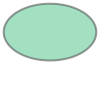

In [136]:
# print geomtry of first row with meters    
gdf_no_fly_zones.iloc[10].geometry

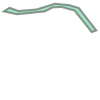

In [137]:
gdf_no_fly_zones.iloc[1].geometry